In [1]:
import pandas as pd

In [2]:
train=pd.read_csv("../Dataset/disaster_tweets_train.csv")
test=pd.read_csv("../Dataset/disaster_tweets_test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train=train.drop(columns=["keyword","location","id"])
test=test.drop(columns=["keyword","location","id"])

In [6]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
len(train["text"][0])

69

In [8]:
train["text_length"]=train["text"].apply(len)
test["text_length"]=test["text"].apply(len)

<Axes: xlabel='count', ylabel='Count'>

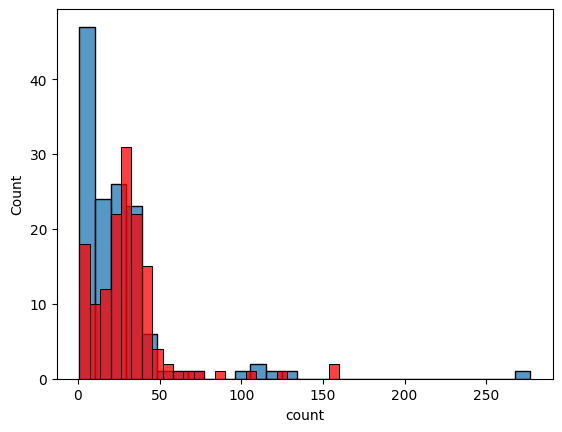

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(train[train["target"]==1]["text_length"].value_counts())
sns.histplot(train[train["target"]==0]["text_length"].value_counts(),color="red")

In [10]:
from nltk.tokenize import sent_tokenize,word_tokenize


train["word_tokens"]=train["text"].apply([lambda x: len(word_tokenize(x))])
test["word_tokens"]=test["text"].apply([lambda x: len(word_tokenize(x))])

In [11]:
train.head()

,text,target,text_length,word_tokens
0,Our Deeds are the Reason of this #earthquake M...,1,69,14
1,Forest fire near La Ronge Sask. Canada,1,38,8
2,All residents asked to 'shelter in place' are ...,1,133,24
3,"13,000 people receive #wildfires evacuation or...",1,65,9
4,Just got sent this photo from Ruby #Alaska as ...,1,88,18


In [12]:
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
import string

stemmer=PorterStemmer()


def preprocess_text(text):
    text=text.lower()
    text=text.translate(str.maketrans('','',string.punctuation))
    doc=word_tokenize(text)
    stemmed=[stemmer.stem(i) for i in doc if i not in stopwords.words("english")]

    converted=" ".join(stemmed)
    return converted

In [13]:
train["preprocessed"]=train["text"].apply(preprocess_text)
test["preprocessed"]=test["text"].apply(preprocess_text)

In [14]:
y=train["target"]
train=train.drop(columns=["target","text"])
test=test.drop(columns=["text"])

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=1000), 'preprocessed'),
    ])

X = preprocessor.fit_transform(train)
X.toarray().shape

(7613, 1000)

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train["preprocessed"].tolist(), y.tolist(), test_size=0.2, random_state=42
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Trainer setup
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Evaluate
trainer.evaluate()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16308\3455454081.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.474300
1000,0.348300


{'eval_loss': 0.49976667761802673,
 'eval_accuracy': 0.8154957321076822,
 'eval_f1': 0.7823392718822618,
 'eval_precision': 0.7866043613707165,
 'eval_recall': 0.7781201848998459,
 'eval_runtime': 136.6319,
 'eval_samples_per_second': 11.147,
 'eval_steps_per_second': 0.703,
 'epoch': 3.0}

In [ ]:
# Tokenize test data
test_texts = test["preprocessed"].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Convert test data to Hugging Face Dataset
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})

# Predict
predictions = trainer.predict(test_dataset)

# Get predicted labels
import numpy as np
pred_labels = np.argmax(predictions.predictions, axis=1)



   id  predicted_label
0   0                1
1   1                1
2   2                1
3   3                1
4   4                1


In [ ]:
# Store in DataFrame and export
submission = pd.DataFrame({
    "id": test.index,     # or another unique identifier if available
    "predicted_label": pred_labels
})

submission.to_csv("bert_predictions.csv", index=False)
print(submission.head())


In [22]:
# Store in DataFrame and export
test=pd.read_csv("../Dataset/disaster_tweets_test.csv")

submission = pd.DataFrame({
    "id": test["id"],     # or another unique identifier if available
    "target": pred_labels
})

submission.to_csv("bert_predictions.csv", index=False)
print(submission.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [ ]:
test.head()

,text_length,word_tokens,preprocessed
0,34,6,happen terribl car crash
1,64,12,heard earthquak differ citi stay safe everyon
2,96,22,forest fire spot pond gees flee across street ...
3,40,7,apocalyps light spokan wildfir
4,45,8,typhoon soudelor kill 28 china taiwan


In [ ]:
x_test=preprocessor.transform(test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()
bayes = MultinomialNB()
model.fit(X_train, y_train)
bayes.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7749562171628721


In [ ]:
y_pred = bayes.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7972854640980735


In [ ]:
pred=bayes.predict(x_test)

In [ ]:
test=pd.read_csv("../Dataset/disaster_tweets_test.csv")

In [ ]:
submission = pd.DataFrame({
    'id': test["id"],      
    'target': pred
})

submission.to_csv('submission.csv', index=False)